# Simulation
**Idea:** Estimate a quadratic treatment effect with a Random Forest while accounting for overfitting on the auxiliary sample.

**TOC:**
* Data Generating Process
* ML Proxy
* GATES and BLP Calculation

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import causaltreat as ct

## Data Generating Process

In [13]:
params = {
    'n': int(5e3),  # Amount of data (more data -> less overfitting)
    'eps_sigma': .1,  # Amount of noise in the data (more noise -> more overfitting)
    'prob_treat': .2,  # Share of treated observations
    'seed': 10285,  # Seed for reproducibility
    'heterogeneity': True,  # Switch between pure noise and quadratic treatment effect in z
    'n_draws': 50,  # Number of draws when estimating distributions
}

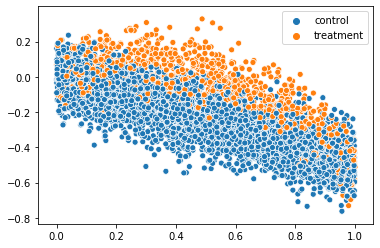

In [14]:
np.random.seed(params['seed'])
z = np.random.uniform(size=params['n'])
x = z.reshape(-1, 1)
b0 = -.5 * z
if params['heterogeneity']:
    s0 = .25 + - (z - .5) ** 2  # quadratic treatment effect
else:
    s0 = np.repeat(0, repeats=params['n'])  # pure noise
d = np.random.choice(
    a=[0,1], 
    p=[1-params['prob_treat'], params['prob_treat']], 
    size=params['n'],
)
eps = np.random.normal(
    loc=0, 
    scale=params['eps_sigma'], 
    size=params['n'],
)
y = b0 + (d * s0) + eps
prop = np.repeat(np.mean(d), repeats=params['n'])  # constant propensity score p(Z) = prop
sample = np.where(d, "treatment", "control")
sns.scatterplot(x=z, y=y, hue=sample)

## ML Proxy for Treatment Effect

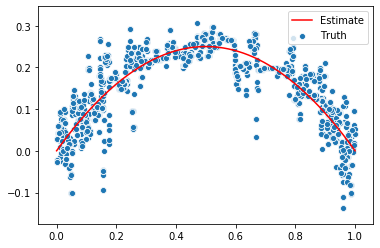

In [15]:
# ML predictor
# Here, params imply that we overfit quite a bit
rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=8, 
    min_samples_leaf=1,
)

# Proxy predictor of treatment effect
b_hat, s_hat = ct.ml_proxy(
    model=rf, 
    x=x, 
    y=y, 
    d=d, 
    sample=np.repeat('a', repeats=len(y)),
)
g, ax = plt.subplots()
sns.scatterplot(x=z, y=s_hat, ax=ax)  # estimate
sns.lineplot(x=z, y=s0, color='red', ax=ax)  # truth
plt.legend(labels=['Estimate', 'Truth'], loc="upper right")
plt.show(g)

## Estimate GATES and BLP

In [16]:
# Estimate Distributions - GATES
results_gates = []
for iteration in tqdm(range(params['n_draws'])):
    results_iteration = ct.combine(
        model=rf, 
        x=x, 
        y=y, 
        d=d, 
        prop=prop, 
        second_stage='gates',
        q=10, 
        prob_m=.5,
    )
    results_gates.append(results_iteration['coef_treatment'])

100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


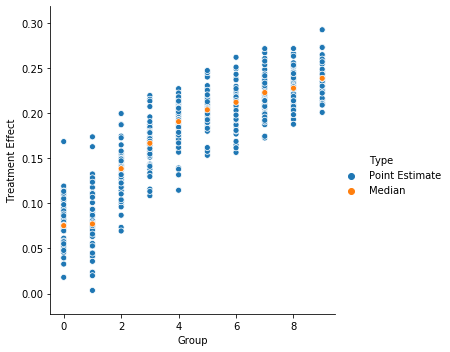

In [17]:
df_plot = pd.DataFrame(data=np.vstack(results_gates))
df_plot = df_plot.melt(var_name='Group', value_name='Treatment Effect')
df_plot['Type'] = 'Point Estimate'

df_plot_summary = pd.DataFrame(data=np.median(np.vstack(results_gates), axis=0).reshape(1,-1))
df_plot_summary = df_plot_summary.melt(var_name='Group', value_name='Treatment Effect')
df_plot_summary['Type'] = 'Median'

sns.relplot(x='Group', y='Treatment Effect', hue='Type', data=df_plot.append(df_plot_summary))

In [18]:
# Estimate Distributions - BLP
results_blp = []
for iteration in tqdm(range(params['n_draws'])):
    
    results_iteration = ct.combine(
        model=rf, 
        x=x, 
        y=y, 
        d=d, 
        prop=prop, 
        second_stage='blp', 
        prob_m=.5,
    )
    results_blp.append(results_iteration)

100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


ate    0.173962
het    0.681013
dtype: float64


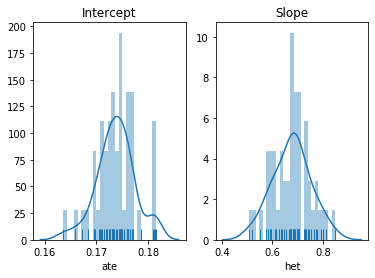

In [19]:
df_plot = pd.DataFrame.from_records(data=results_blp)
print(df_plot.agg('median')) 
fig, ax = plt.subplots(1, 2)
sns.distplot(df_plot['ate'], bins=25, ax=ax[0], label='ATE', rug=True)
sns.distplot(df_plot['het'], bins=25, ax=ax[1], label='HET', rug=True)
ax[0].set_title("Intercept")
ax[1].set_title("Slope")
plt.show(g)

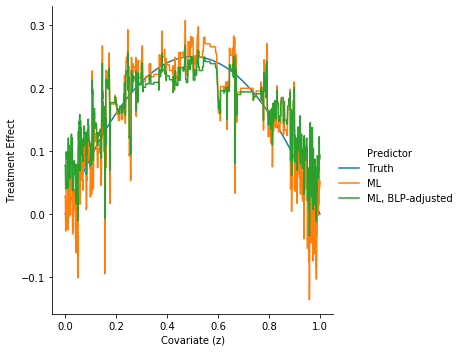

In [20]:
# Calculate BLP
ate = df_plot.agg('median').ate
het = df_plot.agg('median').het

# Plot
df_plot_fun = pd.DataFrame({
    'Covariate (z)':z,
    'Truth':s0,
    'ML':s_hat,
    'ML, BLP-adjusted': ate + het * (s_hat - np.mean(s_hat))
}).melt(id_vars='Covariate (z)', value_name='Treatment Effect', var_name='Predictor')

sns.relplot(
    kind='line',
    x='Covariate (z)', 
    y='Treatment Effect', 
    hue='Predictor',
    data=df_plot_fun)

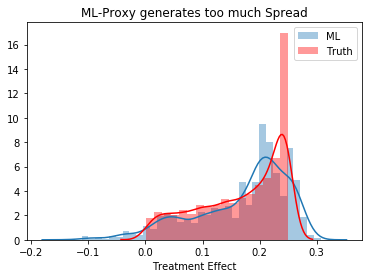

In [21]:
treat_ml = df_plot_fun.query('Predictor == "ML"')['Treatment Effect']
treat_true = df_plot_fun.query('Predictor == "Truth"')['Treatment Effect']

fig, ax = plt.subplots()
sns.distplot(a=treat_ml, ax=ax)
sns.distplot(a=treat_true, color='red', ax=ax)
ax.legend(["ML", "Truth"])
ax.set_title('ML-Proxy generates too much Spread')
plt.show()

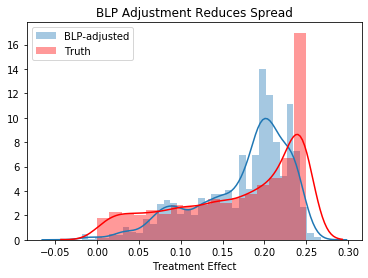

In [22]:
treat_blp = df_plot_fun.query('Predictor == "ML, BLP-adjusted"')['Treatment Effect']
treat_true = df_plot_fun.query('Predictor == "Truth"')['Treatment Effect']

fig, ax = plt.subplots()
sns.distplot(a=treat_blp, ax=ax)
sns.distplot(a=treat_true, color='red', ax=ax)
ax.legend(["BLP-adjusted", "Truth"])
ax.set_title('BLP Adjustment Reduces Spread')
plt.show()